In [5]:
import torch
import cv2
import matplotlib.pyplot as plt

from helper_functions.preprocessing import replace_black_with_median, preprocess_image
from helper_functions.encode import prepare_training_data

# Paths
TRAIN_FOLDER_PATH = "../data/train/combine"
TEST_FOLDER_PATH = "../data/test/combine"

In [2]:
# CNN parameters
IMG_HEIGHT = 40
IMG_WIDTH = 30
BATCH_SIZE = 64
EPOCHS = 15
VALIDATION_SPLIT = 0.2

In [3]:
img = cv2.imread('../data/train/combine/000s-0.png')
processed_img = preprocess_image(img)

cv2.imshow('image', processed_img)

# Wait for a key press (0 means indefinite wait)
cv2.waitKey(0)

# Close all OpenCV windows
cv2.destroyAllWindows()

In [6]:
print("Preparing training data...")
X_img, X_features, y, feature_names, scaler = prepare_training_data(TRAIN_FOLDER_PATH)

Preparing training data...


Preparing Training Data: 100%|████████████████████████████████████████████████████| 7437/7437 [00:28<00:00, 263.54it/s]


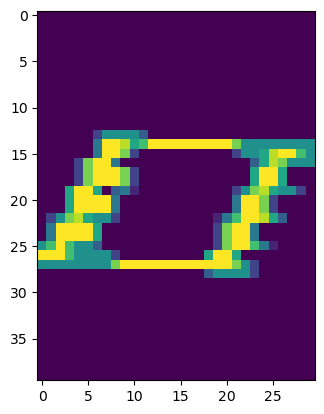

In [7]:
X_img[]